##Imports

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [ ]:
calendar = pd.read_csv('/content/drive/MyDrive/Seattle Airbnb/calendar.csv')
listings = pd.read_csv('/content/drive/MyDrive/Seattle Airbnb/listings.csv')
reviews = pd.read_csv('/content/drive/MyDrive/Seattle Airbnb/reviews.csv')

#Understanding the Data

First, I would like to know what each dataset contains, it's dimensions and data types.

## calendar data

In [ ]:
# peeking at the first few rows of the dataset 
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [ ]:
# detailed summary of information about the datset
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


The calendar dataset has 1393570 rows and 4 columns. The **price** column is of object type but should be treated as integer or float. The **date** column can also be splited into **year, month and date** for better access and analysis.

In [ ]:
# No Missing Values
no_missing_values = set(calendar.columns[calendar.isnull().mean() == 0])
print(f'The following columns have no null values {no_missing_values}')

# Missing Values
missing_values = set(calendar.columns[calendar.isnull().mean() > 0])
print(f'The following columns have null values {missing_values}')

The following columns have no null values {'listing_id', 'date', 'available'}
The following columns have null values {'price'}


In [ ]:
# N/B: rows with 'f' values do not include a price value(i.e null)
check_f = calendar[(calendar['price'] == 'f') & (calendar['available'] == np.nan)].shape[0]
print(check_f)

0


In [ ]:
'''
Data Cleaning for the dataset

1. For the price column, make the column of type 'float' and remove '$' from the
   column and lastly fill the null prices with '0'
2. For the date column, split each date into its respective year, month and date
3. For thw available column, replave 't' values with 1 and 'f' values with 0
'''

calendar['price'].replace('[$,]', '', regex=True, inplace=True)
calendar['price'].fillna(0, inplace=True)
calendar['price'] = calendar['price'].astype('float')

calendar.date = pd.to_datetime(calendar.date) 
calendar['year'] = calendar['date'].dt.year
calendar['month'] = calendar['date'].dt.month
calendar['day'] = calendar['date'].dt.day

calendar['available'].replace({'t': 1, 'f': 0}, inplace = True) 


In [ ]:
# dropping the date column
calendar.drop('date', axis = 1, inplace = True)

In [ ]:
# dropping the rows that are of year 2017 so year 2016 is main focus of analysish

calendar.drop(calendar.index[calendar['year'] == 2017], inplace = True)

In [ ]:
# let's take a look at the dataset after cleaning
calendar.head()

,listing_id,available,price,year,month,day
0,241032,1,85.0,2016,1,4
1,241032,1,85.0,2016,1,5
2,241032,0,0.0,2016,1,6
3,241032,0,0.0,2016,1,7
4,241032,0,0.0,2016,1,8


## listings data


In [ ]:
# peeking at the first few rows of the dataset 
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [ ]:
# detailed summary of information about the datset
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [ ]:
# No Missing Values
no_missing_values = set(listings.columns[listings.isnull().mean() == 0])
print(f'The following columns have no null values {no_missing_values}')

# Missing Values
missing_values = set(listings.columns[listings.isnull().mean() > 0])
print(f'The following columns have null values {missing_values}')

The following columns have no null values {'smart_location', 'city', 'country', 'longitude', 'requires_license', 'extra_people', 'picture_url', 'availability_90', 'calendar_last_scraped', 'calendar_updated', 'price', 'street', 'host_url', 'neighbourhood_cleansed', 'latitude', 'availability_60', 'host_verifications', 'last_scraped', 'has_availability', 'market', 'room_type', 'accommodates', 'guests_included', 'minimum_nights', 'availability_365', 'neighbourhood_group_cleansed', 'name', 'id', 'jurisdiction_names', 'require_guest_profile_picture', 'listing_url', 'amenities', 'calculated_host_listings_count', 'cancellation_policy', 'description', 'number_of_reviews', 'availability_30', 'host_id', 'scrape_id', 'bed_type', 'state', 'experiences_offered', 'maximum_nights', 'country_code', 'require_guest_phone_verification', 'instant_bookable', 'is_location_exact'}
The following columns have null values {'neighborhood_overview', 'security_deposit', 'square_feet', 'first_review', 'host_neighbou

The listings dataset is larger than the calendar datset in terms of column size. It has 3818 rows and 92 columns. There are alot of columns that are of type 'object' but should be of type 'integer' or 'float'. 

##reviews data

In [ ]:
# peeking at the first few rows of the dataset
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [ ]:
# detailed summary of information about the datset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


The reviews dataset has 84849 rows and 6 columns. The **date** column can be splited into year, month and date for better access and analysis.

In [ ]:
# No Missing Values
no_missing_values = set(reviews.columns[reviews.isnull().mean() == 0])
print(f'The following columns have no null values {no_missing_values}')

# Missing Values
missing_values = set(reviews.columns[reviews.isnull().mean() > 0])
print(f'The following columns have null values {missing_values}')

The following columns have no null values {'date', 'reviewer_id', 'listing_id', 'reviewer_name', 'id'}
The following columns have null values {'comments'}


In [ ]:
'''
Data Cleaning for the dataset
1. For the date column, split each date into its respective year, month and date
'''

reviews.date = pd.to_datetime(reviews.date)
reviews['year'] = reviews['date'].dt.year
reviews['month'] = reviews['date'].dt.month
reviews['day'] = reviews['date'].dt.day

In [ ]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month,day
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...,2015,7,19
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...,2015,7,20
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb...",2015,7,26
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...,2015,8,2
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...,2015,8,10


#**Questions**
1. Describe the vibe of each Seattle neighbourhood using listing descriptions.
2. What are the busiest time of the year to visit Seattle? By how much do prices spike?
3. Is there a general upward trend to both new Airbnb listings and total Airbnb visitors to Seattle?

###1. Describe the vibe of each Seattle neighbourhood using listing descriptions.

In the listings dataset, the neighbourhood column tells us the different neighbourhood in Seattle that have an Airbnb listing,we can use this column alongside the description column which describes the listings to tell us the vibe of the listings of these neighbourhoods.

To get the vibe of the neighbourhood using description, we will need to do some text processing to understand what the main words describing the listings are.

In [ ]:
listings['neighbourhood'].value_counts()

Capitol Hill          351
Ballard               213
Belltown              204
Minor                 192
Queen Anne            187
                     ... 
Pike Market             2
South Park              2
North College Park      1
Fairmount Park          1
Roxhill                 1
Name: neighbourhood, Length: 81, dtype: int64

In [ ]:
'''
Data Cleaning
1. For the neighbourhood column, we take out the rows containing null values
2. Create a new dataframe using the neighbourhood and description columns to 
   analyze the data and determine neighbourhood vibes.
'''

no_null_neighbourhood = listings.dropna(subset = ['neighbourhood'])
no_null_neighbourhood = no_null_neighbourhood[['neighbourhood', 'description']]
no_null_neighbourhood = no_null_neighbourhood.groupby('neighbourhood').agg(lambda id : id.tolist()).reset_index()

no_null_neighbourhood.head()


,neighbourhood,description
0,Alki,[ Alki Beach House located steps from Alki Bea...
1,Arbor Heights,[Darling mother in law studio in quiet n'hood ...
2,Atlantic,[New construction town home near Judkins Park....
3,Ballard,[You'll feel right at home in our private entr...
4,Belltown,[Enjoy modern luxury just a few minutes walk f...


In [ ]:
# create a list containing all the different neighbourhoods
neighbours_list = no_null_neighbourhood['neighbourhood'].tolist() 
print(neighbours_list)

do_not_process = ['bedroom', 'apartment', 'bathroom', 'sqft', 'sq', 'ft', 'bed', 'beds', 'bath', 'br', 'ba']

['Alki', 'Arbor Heights', 'Atlantic', 'Ballard', 'Belltown', 'Bitter Lake', 'Brighton', 'Broadview', 'Broadway', 'Bryant', 'Capitol Hill', 'Cedar Park', 'Central Business District', 'Columbia City', 'Crown Hill', 'Dunlap', 'Eastlake', 'Fairmount Park', 'Fauntleroy', 'First Hill', 'Fremont', 'Gatewood', 'Genesee', 'Georgetown', 'Green Lake', 'Greenwood', 'Haller Lake', 'Harrison/Denny-Blaine', 'High Point', 'Highland Park', 'Holly Park', 'Industrial District', 'Interbay', 'International District', 'Laurelhurst', 'Leschi', 'Licton Springs', 'Lower Queen Anne', 'Madison Park', 'Madrona', 'Magnolia', 'Maple Leaf', 'Mathews Beach', 'Meadowbrook', 'Minor', 'Montlake', 'Mount Baker', 'North Admiral', 'North Beach/Blue Ridge', 'North Beacon Hill', 'North College Park', 'North Delridge', 'Olympic Hills', 'Phinney Ridge', 'Pike Market', 'Pike Place Market', 'Pinehurst', 'Pioneer Square', 'Portage Bay', 'Queen Anne', 'Rainier Beach', 'Ravenna', 'Riverview', 'Roosevelt', 'Roxhill', 'Seaview', 'Sew

This function is used to pre-process the description text in order to extract the top words in the description

In [ ]:
def pre_process(description):

  '''
  INPUT:
  description - the text you want pre-processed

  OUTPUT:
  processed_description - a list containing the words in decription without 
    a. punctuations
    b. special characters
    c. numbers
    d. uppercase letters
    e. spaces
    f. words in the neighbors_list
  '''
  processed_description = []

  for desc in description:
    desc = desc.lower()
    desc = re.sub("","",desc) 

    desc = re.sub('\W+', ' ', desc)
    desc = re.sub('\d+', ' ', desc)
    desc = desc.split()
    
    desc = ' '.join([word for word in desc if word not in (neighbours_list)])
        
    processed_description.append(desc)
  return processed_description

In [ ]:
def top_words(desc):
  '''
  INPUT:
  desc - text you want to extract top words from

  OUTPUT:
  words - list of five(7) words that are most frequent in text
  '''
  vectorizer = CountVectorizer(stop_words= 'english')
  vectorizer.fit(desc)
  vector = vectorizer.transform(desc)
  
  words = list(vectorizer.vocabulary_.keys())[:7]
  return words

In [ ]:
no_null_neighbourhood['description'] = no_null_neighbourhood['description'].apply(lambda desc : pre_process(desc))
no_null_neighbourhood.head()

,neighbourhood,description
0,Alki,[alki beach house located steps from alki beac...
1,Arbor Heights,[darling mother in law studio in quiet n hood ...
2,Atlantic,[new construction town home near judkins park ...
3,Ballard,[you ll feel right at home in our private entr...
4,Belltown,[enjoy modern luxury just a few minutes walk f...


In [ ]:
no_null_neighbourhood['vibe'] = no_null_neighbourhood['description'].apply(lambda desc: top_words(desc))
#neighbourhood_vibe = no_null_neighbourhood.drop('description', axis=1)
#neighbourhood_vibe.head()
no_null_neighbourhood.head()

,neighbourhood,description,vibe
0,Alki,[alki beach house located steps from alki beac...,"[alki, beach, house, located, steps, love, sle..."
1,Arbor Heights,[darling mother in law studio in quiet n hood ...,"[darling, mother, law, studio, quiet, hood, co..."
2,Atlantic,[new construction town home near judkins park ...,"[new, construction, town, home, near, judkins,..."
3,Ballard,[you ll feel right at home in our private entr...,"[ll, feel, right, home, private, entrance, apa..."
4,Belltown,[enjoy modern luxury just a few minutes walk f...,"[enjoy, modern, luxury, just, minutes, walk, w..."


In [ ]:
print(f'Seattle Neighbourhoods and their Vibes according to Seattle 2016 Airbnb Data')
for i in range(len(no_null_neighbourhood)):
  print(f'Neighbourhood : {no_null_neighbourhood["neighbourhood"][i]}')
  print(f'Vibes: {no_null_neighbourhood["vibe"][i]} \n')

Seattle Neighbourhoods and their Vibes according to Seattle 2016 Airbnb Data
Neighbourhood : Alki
Vibes: ['alki', 'beach', 'house', 'located', 'steps', 'love', 'sleeps'] 

Neighbourhood : Arbor Heights
Vibes: ['darling', 'mother', 'law', 'studio', 'quiet', 'hood', 'convenient'] 

Neighbourhood : Atlantic
Vibes: ['new', 'construction', 'town', 'home', 'near', 'judkins', 'park'] 

Neighbourhood : Ballard
Vibes: ['ll', 'feel', 'right', 'home', 'private', 'entrance', 'apartment'] 

Neighbourhood : Belltown
Vibes: ['enjoy', 'modern', 'luxury', 'just', 'minutes', 'walk', 'washington'] 

Neighbourhood : Bitter Lake
Vibes: ['spacious', 'bedroom', 'apartment', 'modern', 'clean', 'affordable', 'minute'] 

Neighbourhood : Brighton
Vibes: ['private', 'apartment', 'basement', 'renovated', 'home', 'quiet', 'neighborhood'] 

Neighbourhood : Broadview
Vibes: ['modern', 'beds', 'queens', 'twin', 'bedrooms', 'baths', 'dedicated'] 

Neighbourhood : Broadway
Vibes: ['private', 'maximum', 'minutes', 'seatt

###2. What are the busiest time of the year to visit Seattle? By how much do prices spike?

In the calendar dataset, the **available** column can give us more insight in what times of the year are most busy to visit Seattle. The **price** column also can give insight into how prices spike over the year in Seattle AIrbnb listings.

In [ ]:
# listings that are available
available_listings = calendar[calendar.available != 0]

# listings that are not available
non_available_listings = calendar[calendar.available != 1]

In [ ]:
available = calendar.groupby('month')['available'].mean()

In [ ]:
available.head(13)

month
1     0.554133
2     0.662208
3     0.709187
4     0.663847
5     0.675670
6     0.674384
7     0.627097
8     0.645051
9     0.674402
10    0.696514
11    0.713986
12    0.735573
Name: available, dtype: float64

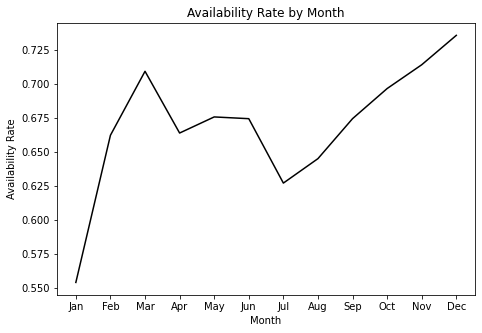

In [ ]:
plt.figure(figsize = (7.5,5))
plt.plot(available, color = 'black')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel("Month")
plt.ylabel("Availability Rate")
plt.title('Availability Rate by Month')
plt.show()

From the above plot, listings are less available in the month of January and July indicating the month of January July could be the busiest months of the year in Seattle.

Now, let's take a look at how the price flunctuate through the months.

In [ ]:
avg_price_monthly = available_listings.groupby('month')['price'].mean()

In [ ]:
avg_price_monthly.head(13)

month
1     121.568409
2     124.293927
3     128.644488
4     135.097005
5     139.538183
6     147.473137
7     152.094150
8     150.656594
9     143.255949
10    137.031939
11    135.688738
12    137.251835
Name: price, dtype: float64

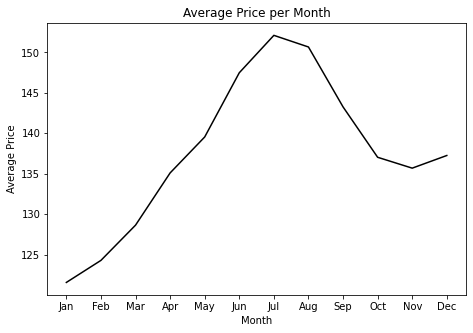

In [ ]:
plt.figure(figsize = (7.5,5))
plt.plot(avg_price_monthly, color = 'black')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.title('Average Price per Month')
plt.show()

From the above plot, the month of July has a high spike in average price and indicates that listings are most expensive in the month of July. Prices are lower in the months of January, February, March, April, November.

---



*` From the information gotten from the two plots above, we can deduce that the busiest time of the year for Seattle Airbnb 2016 is July because listings availability is at its lowest and average listing prices is at its highest in the same month.`*



###3. Is there a general upward trend to both new Airbnb listings and total Airbnb visitors to Seattle?

**Upward trend to new Airbnb listings**
> In the listings dataset, the column **host-since** gives information about the first year the listing was published on Airbnb. We can use this column information to know the trend about Airbnb listings in Seattle.



In [ ]:
'''
From the host-since column, we can extract the year the listing was first 
created and count the amount of listings created for each year and create 
the plot.
'''
listings.host_since = pd.to_datetime(listings.host_since)

listings['host_since_year'] = listings['host_since'].dt.year
trend = listings['host_since_year'].value_counts().sort_index()

In [ ]:
trend.head()

2008.0      4
2009.0     64
2010.0    149
2011.0    398
2012.0    539
Name: host_since_year, dtype: int64

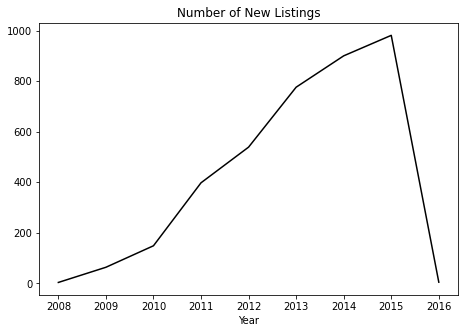

In [ ]:
plt.figure(figsize = (7.5,5))
plt.plot(trend, color = 'black')
plt.xlabel('Year')
plt.title('Number of New Listings')
plt.show()

From the above plot, we can deduce that there is a definite rise in the amount of Airbnb listings over the years. The numbers have increased notably from 2008-2015. For 2016, the number of new listings is especially low, this can be due to the fact that information about 2016 listings was still being collected as at the time this dataset was published. We can therefore assume that the data for 2016 is incomplete.

---



**Upward trend to Airbnb visitor to Seattle**


> In the reviews dataset, we can group the total number of reviews by year and plot the values to see if there has been a decreasing or increasing trend in the number of reviews. This information can also tell us if there has been an upward trend to the number of visitors to Seattle because reviews are mainly written by visitors.


In [ ]:
review_count_by_year  = reviews.groupby('year')['id'].count()

review_count_by_year.head(10)

year
2009       17
2010      254
2011     1169
2012     3251
2013     7077
2014    20365
2015    52493
2016      223
Name: id, dtype: int64

In [ ]:
review_count_by_year = review_count_by_year.to_frame().reset_index()

In [ ]:
review_count_by_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    8 non-null      int64
 1   id      8 non-null      int64
dtypes: int64(2)
memory usage: 256.0 bytes


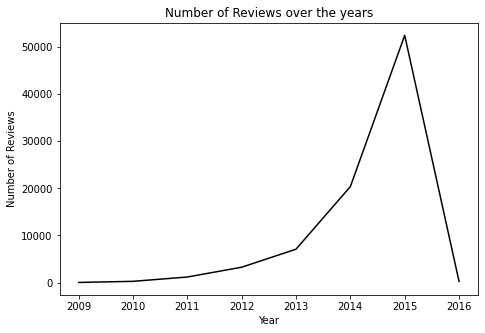

In [ ]:
plt.figure(figsize = (7.5,5))
plt.plot(review_count_by_year['year'], review_count_by_year['id'], color = 'black')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews over the years')
plt.show()

From the above plot, we can deduce that there has been an upward trend in the number of visitors to Seattle from 2009-2015. We notice there is a drastic downfall for 2016, this can be due to the fact that at the time of publishing the dataset, information about reviews for 2016 listings was still being collected and the data was incomplete.

---

